### Part I: Image Classification

#### Dataset
This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:


In [2]:
import cv2
import math
import os
import torch
import torchvision 
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.models as models
import copy
from torch.hub import load_state_dict_from_url
from sklearn.metrics import confusion_matrix
from torch.hub import load_state_dict_from_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import datasets
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from torch.utils.data import Subset
from torchvision.datasets import CIFAR10



import warnings
warnings.filterwarnings("ignore")

In [3]:
# always check your version
print(torch.__version__)

2.1.0+cu121


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview of image classification:**

**1. Function implementation** 

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes 
*   **1.2** PyTorch ```Model``` class for a simple MLP model 
*   **1.3** PyTorch ```Model``` class for a simple CNN model 

**2. Model training** 
*   **2.1** Training on TinyImageNet30 dataset 
*   **2.2** Generating confusion matrices and ROC curves 
*   **2.3** Strategies for tackling overfitting 
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            
**3. Model testing** 
*   **3.1**   Testing your final model in (2) on test set - code to do this 
*   **3.2**   Uploading your result to Kaggle  

**4. Model Fine-tuning on CIFAR10 dataset** 
*   **4.1** Fine-tuning your model (initialise your model with pretrained weights from (2)) 
*   **4.2** Fine-tuning model with frozen base convolution layers 
*   **4.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe.


### 1.1 Dataset class 

In [3]:
# TO COMPLETE
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Apply transformations if specified
        if self.transform:
            img = self.transform(img)

        return img, label

In [25]:
class LoadFromFolder(Dataset):
    def __init__(self, main_dir, transform):
        #Loading directory 
        self.main_dir = main_dir
        self.transform = transform 
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)
        
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, img_loc

In [5]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])
print("ABOUT THE TRAINING DATA")
train_dataset = ImageFolder(root="/Users/sathyasris/Downloads/Assignment - Deep Learning/train_set", transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle= True, num_workers=2)
print(f"Length of Train Data : {len(train_dataset)}")
print(f"Train Dataloader : {train_dataloader}")

print("\n")
print("ABOUT THE LABELS IN THE DATASET")
data=pd.read_csv('/Users/sathyasris/Downloads/Assignment - Deep Learning/class.txt',delimiter = "\t", header=None, names=[0,"Images",2])
data=data.drop(columns=[0,2])
classes=tuple(list(data['Images']))
print(f"The classes in this model are : {classes}")
print(f"The total number of classes are : {len(classes)}")
classes=list(classes)

ABOUT THE TRAINING DATA

Length of Train Data : 13500

Train Dataloader : <torch.utils.data.dataloader.DataLoader object at 0x169751e10>





ABOUT THE LABELS IN THE DATASET

The classes in this model are : ('baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella')

The total number of classes are : 30


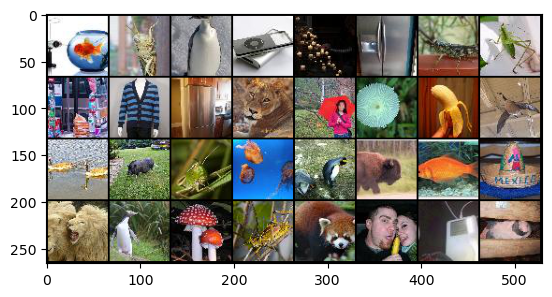

The labels are :  ['goldfish', 'grasshopper', 'penguin', 'ipod', 'candle', 'refrigerator', 'grasshopper', 'grasshopper', 'pretzel', 'cardigan', 'refrigerator', 'lion', 'umbrella', 'mushroom', 'banana', 'goose', 'goose', 'pig', 'grasshopper', 'jellyfish', 'penguin', 'bison', 'goldfish', 'sombrero', 'lion', 'penguin', 'mushroom', 'grasshopper', 'redpanda', 'banana', 'ipod', 'pig']


In [6]:
#Prints a few examples from the dataset, to understand how the data looks. 
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()

# get some random training images using the data loader
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

timshow(torchvision.utils.make_grid(images))

labels_list=[]
for i in range(0,len(labels)):
    labels_list.append(classes[labels[i]])
print("The labels are : ",labels_list)

In [7]:
#Splitting the Training dataset into Training and Validation Dataset - Validation dataset =0.2*Training Dataset in length 
transform_normal = transforms.Compose([
    transforms.Resize(64),  # Resize the image to 32x32
    transforms.ToTensor(),  # Convert the image to PyTorch tensor
])


# Load the entire dataset using ImageFolder
dataset = datasets.ImageFolder(root='/Users/sathyasris/Downloads/Assignment - Deep Learning/train_set', transform=None)
original_classes=dataset.classes


# Split the dataset into training and validation
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Apply transformations to training and validation datasets
train_dataset.dataset.transform = transform_normal
val_dataset.dataset.transform = transform_normal

# Apply label encoding to the class labels
train_labels = [dataset.targets[idx] for idx in train_indices]
val_labels = [dataset.targets[idx] for idx in val_indices]

label_encoder = LabelEncoder()
label_encoder.fit(original_classes)

encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
    
# Create data loaders for training and validation
# adding both original and augumented 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Length of the training dataset:",len(train_dataset))
print("Length of the Validation dataset:",len(val_dataset))
print("Training Data loader:",train_loader)
print("Training Val loader:",val_loader)

Length of the training dataset: 10800

Length of the Validation dataset: 2700

Training Data loader: <torch.utils.data.dataloader.DataLoader object at 0x16de3f350>

Training Val loader: <torch.utils.data.dataloader.DataLoader object at 0x16d3c1c10>


### 1.2 Define a MLP model class 

In [29]:
# TO COMPLETE
# define a MLP Model class
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1=nn.Linear(64*64*3, 256)
        self.relu=nn.ReLU()
        self.layer2=nn.Linear(256,64)
        self.layer3=nn.Linear(64,30)
    def forward(self,x):
        x=self.flatten(x)
        x=self.relu(self.layer1(x))
        x=self.relu(self.layer2(x))
        out=self.layer3(x)
        return out 
model_MLP = MLP()
criterion_MLP=nn.CrossEntropyLoss()
optimizer_MLP=torch.optim.Adam(model_MLP.parameters(), lr=0.001, weight_decay=0.001)
print(model_MLP)

MLP(

  (flatten): Flatten(start_dim=1, end_dim=-1)

  (layer1): Linear(in_features=12288, out_features=256, bias=True)

  (relu): ReLU()

  (layer2): Linear(in_features=256, out_features=64, bias=True)

  (layer3): Linear(in_features=64, out_features=30, bias=True)

)


### 1.3 Define a CNN model class 

In [35]:
# TO COMPLETE
# define a CNN Model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.flatten=nn.Flatten()
        self.conv1=nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
        self.conv5=nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.fclayer1=nn.Linear(512*8, 512)
        self.fclayer2=nn.Linear(512,128)
        self.fclayer3=nn.Linear(128,64)
        self.fclayer4=nn.Linear(64,30)
        self.relu=nn.ReLU()
    def forward(self,x):
        x=self.pool(self.relu(self.conv1(x)))
        x=self.pool(self.relu(self.conv2(x)))
        x=self.pool(self.relu(self.conv3(x)))
        x=self.pool(self.relu(self.conv4(x)))
        x=self.flatten(x)
        x=self.relu(self.fclayer1(x))
        x=self.relu(self.fclayer2(x))
        x=self.relu(self.fclayer3(x))
        out=self.fclayer4(x)
        return out 
model_CNN=CNN()
criterion_CNN=nn.CrossEntropyLoss()
optimizer_CNN=torch.optim.Adam(model_CNN.parameters(), lr=0.0001, weight_decay=0.001)
print(model_CNN)

CNN(

  (flatten): Flatten(start_dim=1, end_dim=-1)

  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  (fclayer1): Linear(in_features=4096, out_features=512, bias=True)

  (fclayer2): Linear(in_features=512, out_features=128, bias=True)

  (fclayer3): Linear(in_features=128, out_features=64, bias=True)

  (fclayer4): Linear(in_features=64, out_features=30, bias=True)

  (relu): ReLU()

)


## 2 Model training 


### 2.1 Train both MLP and CNN model - show loss and accuracy graphs side by side 


In [16]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [17]:
def train_and_val(model,num_epochs,criterion,optimizer):
    training_loss=[]
    validation_loss=[]
    training_accuracy=[]
    validation_accuracy=[]
    #Iterating through each epoch
    for epoch in range(num_epochs):
        #Training the Dataset part
        model.train()
        train_loss, correct_pred_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            labels = torch.tensor(labels)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _,predicted=torch.max(outputs.data,1)
            total_train +=labels.size(0)
            correct_pred_train+=(predicted==labels).sum().item()
        train_loss=train_loss/len(train_loader)
        train_acc=100*correct_pred_train/total_train
    
        #Validation Dataset part 
        model.eval()
        val_loss, correct_pred_val, total_val = 0.0, 0,0
        with torch.no_grad():
            for images,labels in val_loader:
                labels = torch.tensor(labels)
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                _,predicted=torch.max(outputs.data,1)
                total_val +=labels.size(0)
                correct_pred_val+=(predicted==labels).sum().item()
        val_loss=val_loss/len(val_loader)
        val_acc=100*correct_pred_val/total_val
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_accuracy.append(train_acc)
        validation_accuracy.append(val_acc)
    
        print(f'Epoch [{epoch+1}/{num_epochs}],TL: {train_loss:.4f}, TA: {train_acc:.2f}%, VL: {val_loss:.4f}, VA: {val_acc:.2f}%')
    return training_loss, validation_loss,training_accuracy, validation_accuracy

In [30]:
#TO COMPLETE --> Running your MLP model class
num_epochs=50
training_loss,validation_loss,training_accuracy,validation_accuracy = train_and_val(model_MLP,
                                            num_epochs,criterion=criterion_MLP,optimizer=optimizer_MLP)

Epoch [1/50],TL: 3.3502, TA: 5.34%, VL: 3.2685, VA: 7.41%

Epoch [2/50],TL: 3.1964, TA: 9.32%, VL: 3.1004, VA: 11.48%

Epoch [3/50],TL: 3.0841, TA: 11.29%, VL: 3.1068, VA: 11.30%

Epoch [4/50],TL: 3.0245, TA: 12.79%, VL: 3.0313, VA: 13.85%

Epoch [5/50],TL: 2.9851, TA: 13.62%, VL: 3.0781, VA: 13.00%

Epoch [6/50],TL: 2.9608, TA: 14.39%, VL: 2.9315, VA: 15.22%

Epoch [7/50],TL: 2.9191, TA: 15.37%, VL: 2.9057, VA: 16.04%

Epoch [8/50],TL: 2.9044, TA: 15.51%, VL: 2.9180, VA: 15.33%

Epoch [9/50],TL: 2.8879, TA: 16.12%, VL: 3.0873, VA: 13.30%

Epoch [10/50],TL: 2.8767, TA: 16.36%, VL: 2.8726, VA: 17.19%

Epoch [11/50],TL: 2.8572, TA: 16.69%, VL: 2.8782, VA: 16.30%

Epoch [12/50],TL: 2.8448, TA: 17.23%, VL: 2.8934, VA: 15.85%

Epoch [13/50],TL: 2.8417, TA: 17.20%, VL: 2.8631, VA: 17.59%

Epoch [14/50],TL: 2.8409, TA: 17.64%, VL: 2.8794, VA: 17.26%

Epoch [15/50],TL: 2.8275, TA: 18.07%, VL: 2.8369, VA: 18.04%

Epoch [16/50],TL: 2.8168, TA: 18.56%, VL: 2.8538, VA: 17.78%

Epoch [17/50],TL: 2.

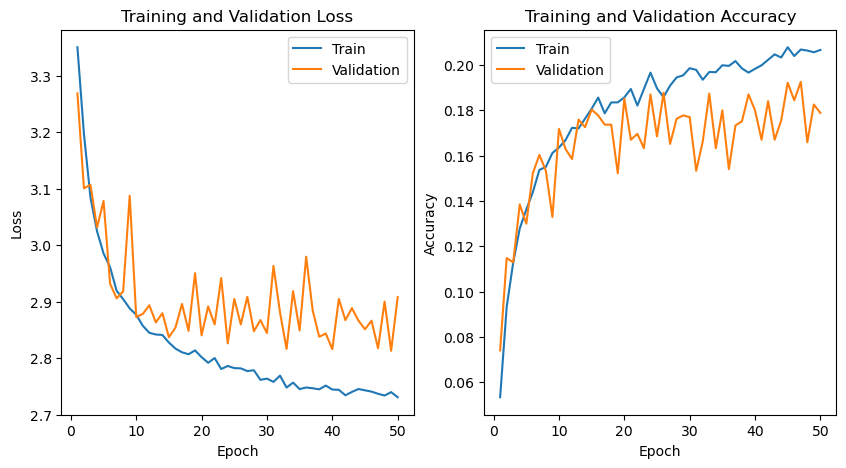

In [31]:
# Your graph - MLP model
training_accuracy=[training_accuracy[i]/100 for i in range(0,len(training_accuracy))]
validation_accuracy=[validation_accuracy[i]/100 for i in range(0,len(validation_accuracy))]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_loss, label='Train')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), training_accuracy, label='Train')
plt.plot(range(1, num_epochs + 1), validation_accuracy, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [36]:
#TO COMPLETE --> Running your CNN model class
num_epochs=30
training_loss,validation_loss,training_accuracy,validation_accuracy = train_and_val(model_CNN,
                                            num_epochs,criterion=criterion_CNN,optimizer=optimizer_CNN)

Epoch [1/30],TL: 3.4035, TA: 3.14%, VL: 3.4023, VA: 3.26%

Epoch [2/30],TL: 3.3854, TA: 4.26%, VL: 3.3327, VA: 5.22%

Epoch [3/30],TL: 3.2898, TA: 6.55%, VL: 3.2658, VA: 5.85%

Epoch [4/30],TL: 3.2142, TA: 8.41%, VL: 3.1866, VA: 8.81%

Epoch [5/30],TL: 3.1513, TA: 10.04%, VL: 3.1135, VA: 11.15%

Epoch [6/30],TL: 3.0892, TA: 10.90%, VL: 3.0617, VA: 11.19%

Epoch [7/30],TL: 3.0456, TA: 11.90%, VL: 3.0352, VA: 13.00%

Epoch [8/30],TL: 3.0052, TA: 12.82%, VL: 2.9698, VA: 13.11%

Epoch [9/30],TL: 2.9713, TA: 13.79%, VL: 2.9545, VA: 14.96%

Epoch [10/30],TL: 2.9292, TA: 15.31%, VL: 2.8886, VA: 16.07%

Epoch [11/30],TL: 2.8925, TA: 15.81%, VL: 2.8580, VA: 16.96%

Epoch [12/30],TL: 2.8523, TA: 16.95%, VL: 2.8404, VA: 17.93%

Epoch [13/30],TL: 2.8102, TA: 17.49%, VL: 2.7972, VA: 18.78%

Epoch [14/30],TL: 2.7625, TA: 19.15%, VL: 2.7437, VA: 19.67%

Epoch [15/30],TL: 2.7174, TA: 20.24%, VL: 2.7059, VA: 21.74%

Epoch [16/30],TL: 2.6808, TA: 21.45%, VL: 2.6633, VA: 22.19%

Epoch [17/30],TL: 2.6428,

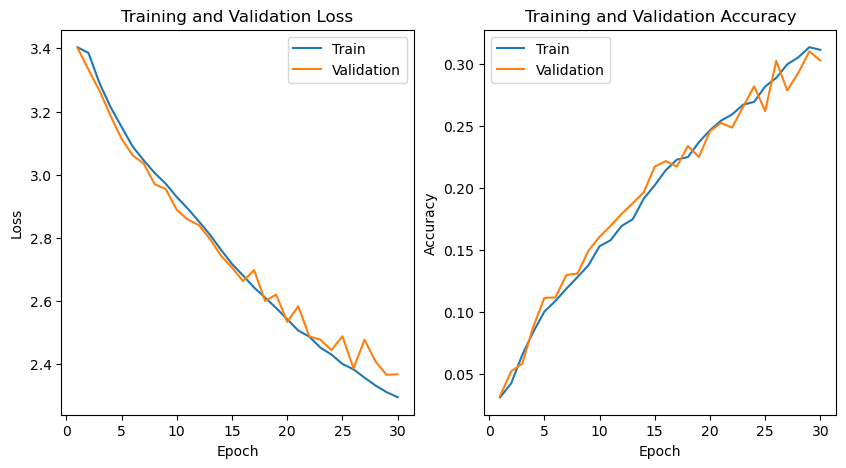

In [37]:
# Your graph
training_accuracy=[training_accuracy[i]/100 for i in range(0,len(training_accuracy))]
validation_accuracy=[validation_accuracy[i]/100 for i in range(0,len(validation_accuracy))]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_loss, label='Train')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), training_accuracy, label='Train')
plt.plot(range(1, num_epochs + 1), validation_accuracy, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

> Comment on your model and the results you have obtained. This should include the number of parameters for each of your models and briefly explain why one should use CNN over MLP for the image classification problem.

> About MLP Model - Its a multi layer perceptron, which has 4 fully connected Linear layers, Activation function which is RelU,Flatten Layer ,Loss function is CrossEntropyLoss() and the optimizer used is Adam with a learning rate of 0.001. Based on the outputs that were got for the MLP model the validation and training loss starts off high and tends to decrease as the model trains on the data this indicates that the model is learning well. 

> About CNN Model - Its a convolutional neural network which consits of the flatten layer, 5 convolutional layers, Max pooling layer, 4 fully connected layers and relu activation function. The Loss function used here is CrossEntropyLoss() and the optimizer used is Adam with a learning rate of 0.001.Based on the outputs that were got for this model we can say that the training and validation loss decrease well, and the accuracies increase with each epoch which is a good sign. 

> CNN is better than MLP for image classification because CNN's are built to recognise patterns and learn and understand them, making them great for tasks like identifying objects in pictures. They are also good at handling large images because they can focus on relevant parts because of parameter sharing and pooling layers present. 

### 2.2 Generating confusion matrix and ROC curves 

In [38]:
# Your code here!
# Predicting for Training and Validation Set 
train_predictions=[]
train_true=[]
val_predictions=[]
val_true=[]
model_CNN.eval()
with torch.no_grad():
    for images, labels in train_loader:
        outputs=model_CNN(images)
        _,predicted=torch.max(outputs,1)
        train_predictions +=predicted.tolist()
        train_true+=labels.tolist()
    for images,labels in val_loader:
        outputs=model_CNN(images)
        _,predicted=torch.max(outputs,1)
        val_predictions +=predicted.tolist()
        val_true+=labels.tolist()

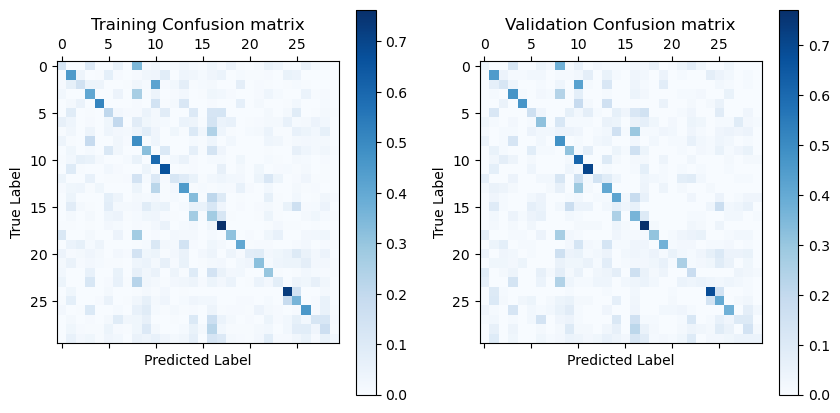

In [39]:
#Confusion Matrix 
train_CM = confusion_matrix(train_true,train_predictions)
val_CM = confusion_matrix(val_true,val_predictions)
train_CM=train_CM/train_CM.sum(axis=1,keepdims=True)
val_CM=val_CM/val_CM.sum(axis=1,keepdims=True)
train_CM=np.array(train_CM)
val_CM=np.array(val_CM)

fig, ax = plt.subplots(1,2,figsize=(10,5))

#Training Confusion Matrix 
cax1=ax[0].matshow(train_CM,cmap='Blues')
fig.colorbar(cax1,ax=ax[0])
ax[0].set_title("Training Confusion matrix")
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')

#Validation confusion matrix 
cax2=ax[1].matshow(val_CM,cmap='Blues')
fig.colorbar(cax2,ax=ax[1])
ax[1].set_title("Validation Confusion matrix")
ax[1].set_xlabel('Predicted Label')
ax[1].set_ylabel('True Label')

plt.show()

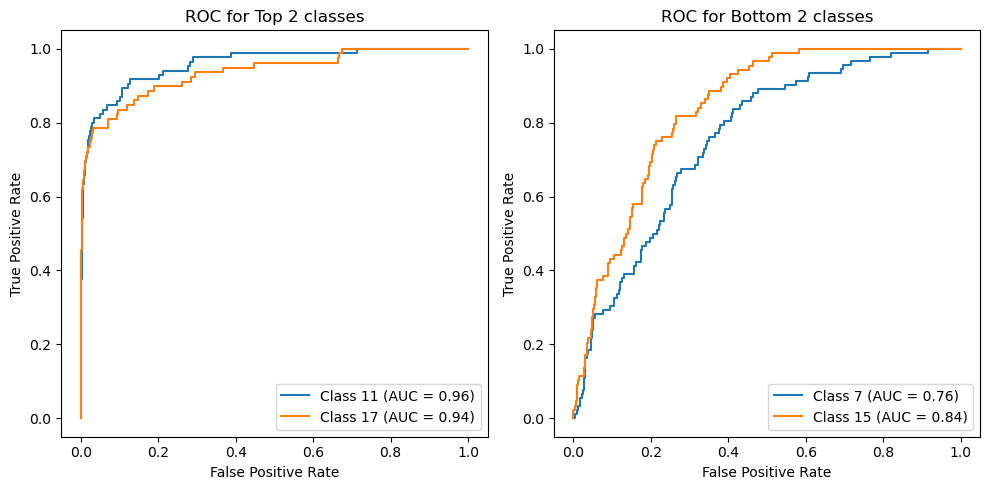

In [41]:
#Region under the Curve - ROC 
model_CNN.eval()
true_labels=[]
predicted_prob=[]

for images,labels in val_loader:
    outputs=model_CNN(images)
    prob=torch.softmax(outputs,dim=1)
    true_labels.extend(labels.detach().numpy())
    predicted_prob.extend(prob.detach().numpy())

true_labels=np.array(true_labels)
predicted_probs=np.array(predicted_prob)

top_2 = np.argsort(predicted_probs.max(axis=0))[-2:]
bottom_2 = np.argsort(predicted_probs.max(axis=0))[:2] #shows na AUC Classes 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for class_index in top_2:
    fpr,tpr, _ = roc_curve(true_labels==class_index, predicted_probs[:,class_index])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label = f'Class {class_index} (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Top 2 classes")
plt.legend()

plt.subplot(1,2,2)
for class_index in bottom_2:
    fpr,tpr, _ = roc_curve(true_labels==class_index, predicted_probs[:,class_index])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, label = f'Class {class_index} (AUC = {roc_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Bottom 2 classes")
plt.legend()

plt.tight_layout()
plt.show()

### Redesign your CNN model (optional)


In [48]:
# Your code here (optional)
#Adding Batch Normalization to the code and making it 4 convolutional layers
class Final_CNN(nn.Module):
    def __init__(self):
        super(Final_CNN,self).__init__()
        self.flatten=nn.Flatten()
        self.conv1=nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1=nn.Linear(256*16, 512)
        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(64)
        self.bn3=nn.BatchNorm2d(128)
        self.bn4=nn.BatchNorm2d(256)
        self.relu=nn.ReLU()
        self.layer2=nn.Linear(512,128)
        self.layer3=nn.Linear(128,64)
        self.layer4=nn.Linear(64,30)
    def forward(self,x):
        x=self.pool(self.relu(self.bn1(self.conv1(x))))
        x=self.pool(self.relu(self.bn2(self.conv2(x))))
        x=self.pool(self.relu(self.bn3(self.conv3(x))))
        x=self.pool(self.relu(self.bn4(self.conv4(x))))
        #Flattening before sending it to the fully connected layers
        x=self.flatten(x)
        x=self.relu(self.layer1(x))
        x=self.relu(self.layer2(x))
        x=self.relu(self.layer3(x))
        out=self.layer4(x)
        return out 
model_CNN_up=Final_CNN()
criterion_CNN_up=nn.CrossEntropyLoss()
optimizer_CNN_up=torch.optim.Adam(model_CNN_up.parameters(), lr=0.0001, weight_decay=0.001)
print(model_CNN_up)

Final_CNN(

  (flatten): Flatten(start_dim=1, end_dim=-1)

  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  (layer1): Linear(in_features=4096, out_features=512, bias=True)

  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (relu): ReLU()

  (layer2): Linear(in_features=512, out_features=128, bias=True)

  (layer3): Linear(in_featur

In [49]:
#Training this model
num_epochs=15
training_loss,validation_loss,training_accuracy,validation_accuracy = train_and_val(model_CNN_up,
                                            num_epochs,criterion=criterion_CNN_up,optimizer=optimizer_CNN_up)

Epoch [1/15],TL: 2.9317, TA: 16.49%, VL: 2.5373, VA: 24.85%

Epoch [2/15],TL: 2.3927, TA: 29.50%, VL: 2.3601, VA: 30.04%

Epoch [3/15],TL: 2.1208, TA: 37.79%, VL: 2.0425, VA: 38.48%

Epoch [4/15],TL: 1.9222, TA: 43.69%, VL: 1.8945, VA: 43.96%

Epoch [5/15],TL: 1.7471, TA: 48.31%, VL: 1.8663, VA: 46.70%

Epoch [6/15],TL: 1.6072, TA: 52.24%, VL: 1.7183, VA: 48.70%

Epoch [7/15],TL: 1.4753, TA: 55.41%, VL: 1.7363, VA: 48.96%

Epoch [8/15],TL: 1.3322, TA: 59.81%, VL: 1.7542, VA: 49.59%

Epoch [9/15],TL: 1.2055, TA: 63.46%, VL: 1.7102, VA: 49.81%

Epoch [10/15],TL: 1.0773, TA: 67.19%, VL: 1.7752, VA: 50.15%

Epoch [11/15],TL: 0.9513, TA: 70.51%, VL: 1.7876, VA: 49.26%

Epoch [12/15],TL: 0.8122, TA: 75.28%, VL: 1.7494, VA: 51.85%

Epoch [13/15],TL: 0.7010, TA: 78.06%, VL: 1.8397, VA: 51.70%

Epoch [14/15],TL: 0.5771, TA: 82.41%, VL: 1.9732, VA: 49.81%

Epoch [15/15],TL: 0.4783, TA: 85.54%, VL: 2.0003, VA: 49.67%


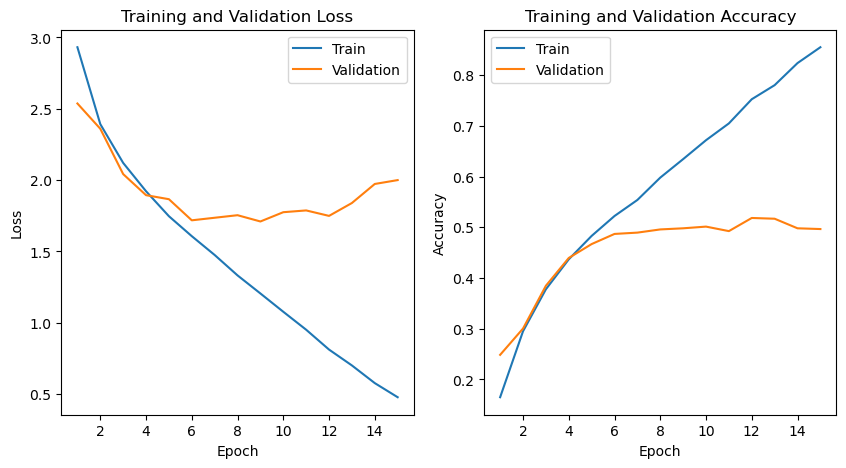

In [50]:
#Plot for the updated model to show training and validation Loss and Accuracy
training_accuracy=[training_accuracy[i]/100 for i in range(0,len(training_accuracy))]
validation_accuracy=[validation_accuracy[i]/100 for i in range(0,len(validation_accuracy))]
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_loss, label='Train')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), training_accuracy, label='Train')
plt.plot(range(1, num_epochs + 1), validation_accuracy, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

### 2.3 Tackling overfitting 

#### 2.3.1 Data augmentation

In [42]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(64), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomRotation(10), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.4439, 0.4229, 0.3309], std=[0.2573, 0.2476, 0.2540]) 
])

transform_val_aug = transforms.Compose([
    transforms.Resize(64), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5077, 0.4602, 0.3570], std=[0.2579, 0.2500, 0.2426])
])

dataset = datasets.ImageFolder(root='/Users/sathyasris/Downloads/Assignment - Deep Learning/train_set', transform=None)
original_classes=dataset.classes


# Split the dataset into training and validation
train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
train_dataset.dataset.transform = transform_train_aug
val_dataset.dataset.transform = transform_val_aug

train_labels = [dataset.targets[idx] for idx in train_indices]
val_labels = [dataset.targets[idx] for idx in val_indices]
label_encoder = LabelEncoder()
label_encoder.fit(original_classes)
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
    

train_loader_aug = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader_aug = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

print("The length of the training dataset:", len(train_dataset))
print("The length of the Validation dataset:",len(val_dataset))
print("Training dataloader after data augumentation: ",train_loader_aug)
print("Validation dataloader after data augumentation: ",val_loader_aug)

The length of the training dataset: 10800

The length of the Validation dataset: 2700

Training dataloader after data augumentation:  <torch.utils.data.dataloader.DataLoader object at 0x31226fb10>

Validation dataloader after data augumentation:  <torch.utils.data.dataloader.DataLoader object at 0x31223c490>


#### 2.3.2 Dropout 

In [56]:
# Your code here!
class Final_CNN_withdrop(nn.Module):
    def __init__(self,prob):
        super(Final_CNN_withdrop,self).__init__()
        self.flatten=nn.Flatten()
        self.conv1=nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1=nn.Linear(256*16, 512)
        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(64)
        self.bn3=nn.BatchNorm2d(128)
        self.bn4=nn.BatchNorm2d(256)
        self.relu=nn.ReLU()
        self.layer2=nn.Linear(512,128)
        self.layer3=nn.Linear(128,64)
        self.layer4=nn.Linear(64,30)
        self.dropout=nn.Dropout(p=prob)
    def forward(self,x):
        x=self.pool(self.relu(self.bn1(self.conv1(x))))
        x=self.pool(self.relu(self.bn2(self.conv2(x))))
        x=self.pool(self.relu(self.bn3(self.conv3(x))))
        x=self.pool(self.relu(self.bn4(self.conv4(x))))
        x=self.dropout(x)
        #Flattening before sending it to the fully connected layers
        x=self.flatten(x)
        x=self.relu(self.layer1(x))
        x=self.relu(self.layer2(x))
        x=self.relu(self.layer3(x))
        out=self.layer4(x)
        return out 

In [22]:
def train_model_with_drop(model,train_loader1,val_loader1,criterion,optimizer,num):
    training_loss=[]
    validation_loss=[]
    training_accuracy=[]
    validation_accuracy=[]
    for epoch in range(num):
        model.train()
        train_loss, correct_pred_train, total_train = 0.0, 0, 0
        for images, labels in train_loader1:
            labels = torch.tensor(labels)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _,predicted=torch.max(outputs.data,1)
            total_train +=labels.size(0)
            correct_pred_train+=(predicted==labels).sum().item()
        train_loss=train_loss/len(train_loader)
        train_acc=100*correct_pred_train/total_train
        
        model.eval()
        val_loss, correct_pred_val, total_val = 0.0, 0,0
        with torch.no_grad():
            for images,labels in val_loader1:
                labels = torch.tensor(labels)
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                _,predicted=torch.max(outputs.data,1)
                total_val +=labels.size(0)
                correct_pred_val+=(predicted==labels).sum().item()
        val_loss=val_loss/len(val_loader)
        val_acc=100*correct_pred_val/total_val
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_accuracy.append(train_acc)
        validation_accuracy.append(val_acc) 
        
        print(f'Epoch [{epoch+1}/{num}],TL: {train_loss:.4f}, TA: {train_acc:.2f}%, VL: {val_loss:.4f}, VA: {val_acc:.2f}%')
        
    return training_loss, validation_loss, training_accuracy, validation_accuracy



Training with this Droput Prob: 0.2

Epoch [1/10],TL: 3.1995, TA: 8.82%, VL: 3.0222, VA: 12.48%

Epoch [2/10],TL: 2.9894, TA: 13.42%, VL: 2.8656, VA: 17.07%

Epoch [3/10],TL: 2.8338, TA: 16.83%, VL: 2.7825, VA: 19.33%

Epoch [4/10],TL: 2.6685, TA: 20.56%, VL: 2.5439, VA: 22.70%

Epoch [5/10],TL: 2.5141, TA: 24.96%, VL: 2.3260, VA: 30.63%

Epoch [6/10],TL: 2.3680, TA: 28.64%, VL: 2.2018, VA: 33.37%

Epoch [7/10],TL: 2.2411, TA: 32.67%, VL: 2.3327, VA: 30.37%

Epoch [8/10],TL: 2.1634, TA: 35.55%, VL: 2.0845, VA: 37.78%

Epoch [9/10],TL: 2.0900, TA: 37.09%, VL: 2.0662, VA: 38.00%

Epoch [10/10],TL: 2.0042, TA: 39.86%, VL: 2.0424, VA: 39.07%



Training with this Droput Prob: 0.3

Epoch [1/10],TL: 3.2070, TA: 8.85%, VL: 3.0271, VA: 12.26%

Epoch [2/10],TL: 2.9987, TA: 13.86%, VL: 2.9039, VA: 15.78%

Epoch [3/10],TL: 2.8569, TA: 16.39%, VL: 2.7195, VA: 19.52%

Epoch [4/10],TL: 2.6930, TA: 19.97%, VL: 2.5446, VA: 23.78%

Epoch [5/10],TL: 2.5531, TA: 23.78%, VL: 2.3935, VA: 27.41%

Epoch [6

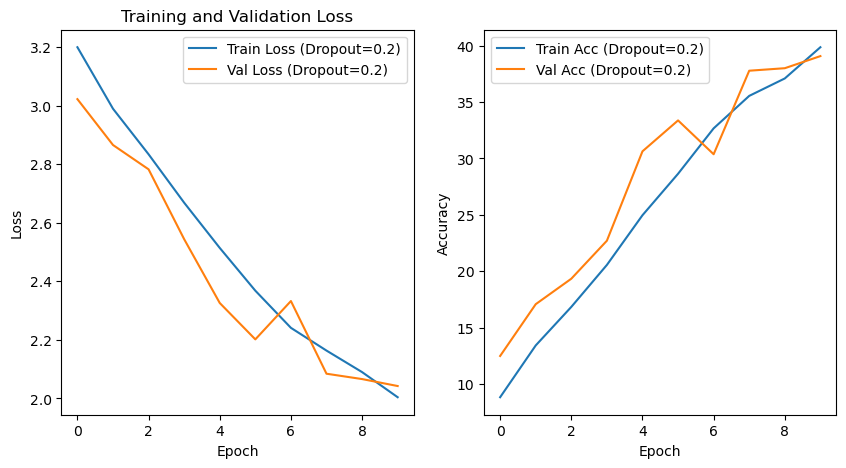

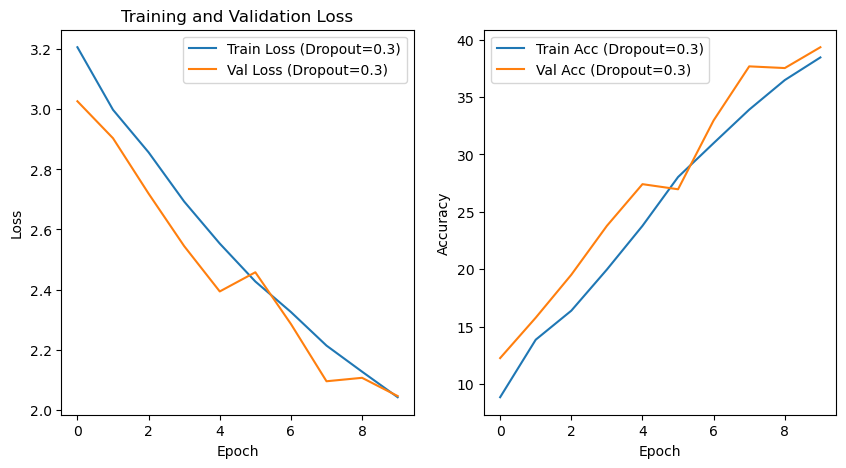

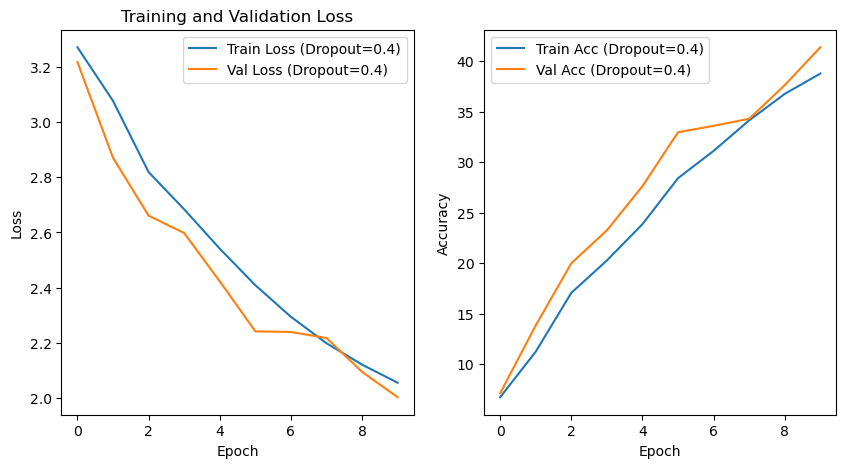

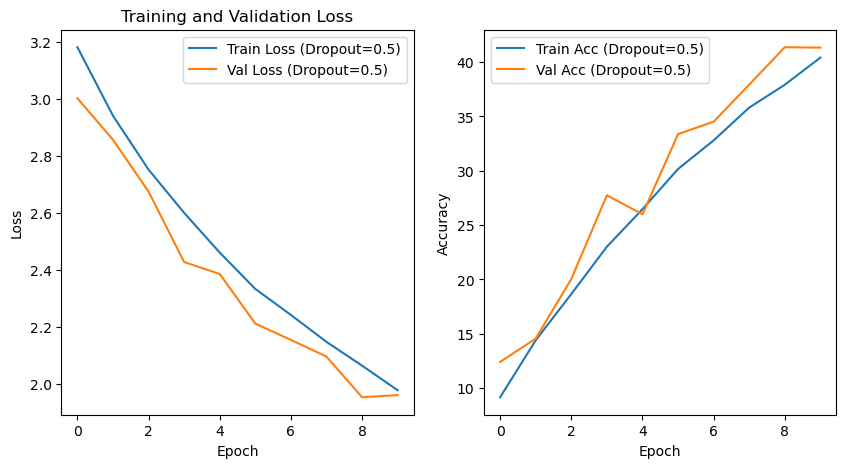

In [58]:
dropout_prob=[0.2,0.3,0.4,0.5]
for p in dropout_prob:
    print(f"\nTraining with this Droput Prob: {p}")
    model=Final_CNN_withdrop(prob=p)
    num=10
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
    training_loss, validation_loss, training_accuracy, validation_accuracy=train_model_with_drop(model, 
                                                        train_loader_aug, val_loader_aug, criterion, optimizer,num)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(training_loss, label=f'Train Loss (Dropout={p})')
    plt.plot(validation_loss, label=f'Val Loss (Dropout={p})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1,2,2)
    plt.plot(training_accuracy, label=f'Train Acc (Dropout={p})')
    plt.plot(validation_accuracy, label=f'Val Acc (Dropout={p})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001].





Training with this Learning Rate: 0.1

Epoch [1/10],TL: 11.4444, TA: 3.31%, VL: 3.4423, VA: 2.93%

Epoch [2/10],TL: 3.4691, TA: 3.43%, VL: 3.4427, VA: 2.93%

Epoch [3/10],TL: 3.5199, TA: 3.35%, VL: 3.4401, VA: 3.41%

Epoch [4/10],TL: 3.4512, TA: 3.29%, VL: 3.4285, VA: 3.74%

Epoch [5/10],TL: 3.4736, TA: 3.45%, VL: 3.4532, VA: 3.33%

Epoch [6/10],TL: 3.4871, TA: 3.26%, VL: 3.4607, VA: 2.93%

Epoch [7/10],TL: 3.4662, TA: 2.98%, VL: 3.4455, VA: 2.93%

Epoch [8/10],TL: 3.4784, TA: 3.41%, VL: 3.4376, VA: 2.93%

Epoch [9/10],TL: 3.4713, TA: 3.19%, VL: 3.4526, VA: 3.74%

Epoch [10/10],TL: 18.0140, TA: 3.18%, VL: 3.4483, VA: 3.59%



Training with this Learning Rate: 0.001

Epoch [1/10],TL: 3.1323, TA: 10.44%, VL: 2.8727, VA: 17.19%

Epoch [2/10],TL: 2.8851, TA: 15.30%, VL: 2.7647, VA: 19.15%

Epoch [3/10],TL: 2.6903, TA: 21.38%, VL: 2.4955, VA: 26.56%

Epoch [4/10],TL: 2.5498, TA: 25.25%, VL: 2.4627, VA: 27.07%

Epoch [5/10],TL: 2.4278, TA: 27.57%, VL: 2.3067, VA: 31.44%

Epoch [6/10],TL: 2

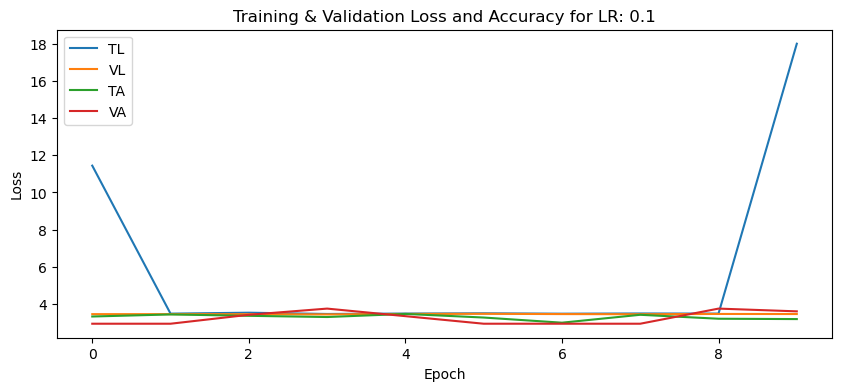

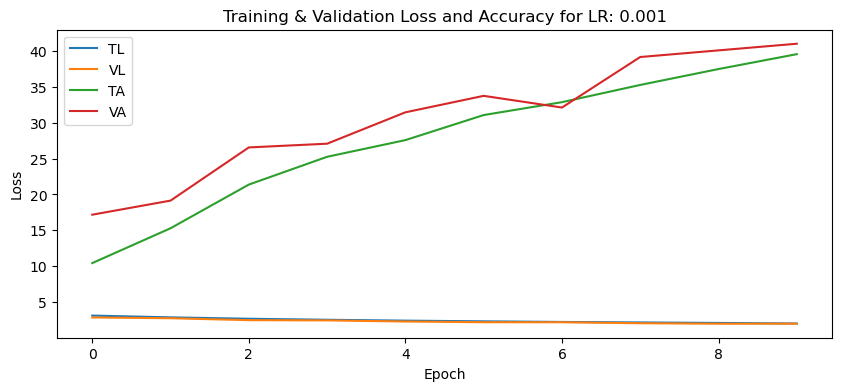

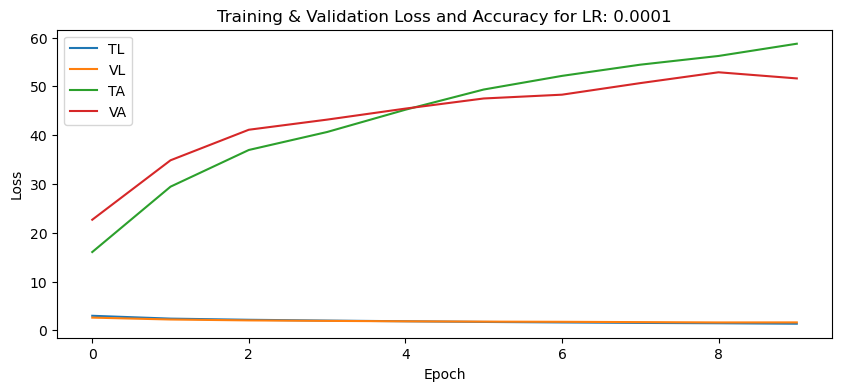

In [59]:
# Your code here!
learning_rates=[0.1,0.001,0.0001]
for value in learning_rates:
    print(f"\nTraining with this Learning Rate: {value}")
    model=Final_CNN_withdrop(prob=0.5)
    num=10
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=value, weight_decay=0.001)
    training_loss, validation_loss, training_accuracy, validation_accuracy=train_model_with_drop(model, 
                                                        train_loader_aug, val_loader_aug, criterion, optimizer,num)
    plt.figure(figsize=(10,4))
    plt.plot(training_loss, label='TL')
    plt.plot(validation_loss, label='VL')
    plt.plot(training_accuracy, label='TA')
    plt.plot(validation_accuracy, label='VA')         
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training & Validation Loss and Accuracy for LR: {value}')

### 3 Model testing [10 marks]
Online evaluation of your model performance on the test set. 

> Prepare the dataloader for the testset.

> Write evaluation code for writing predictions.

> Upload it to Kaggle submission page (6 marks)

In [44]:
#Final CNN 
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.flatten=nn.Flatten()
        self.conv1=nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1)
        self.conv4=nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.layer1=nn.Linear(256*16, 512)
        self.dropout=nn.Dropout(0.5)
        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(64)
        self.bn3=nn.BatchNorm2d(128)
        self.bn4=nn.BatchNorm2d(256)
        self.relu=nn.ReLU()
        self.layer2=nn.Linear(512,128)
        self.layer3=nn.Linear(128,64)
        self.layer4=nn.Linear(64,30)
    def forward(self,x):
        x=self.pool(self.relu(self.bn1(self.conv1(x))))
        x=self.pool(self.relu(self.bn2(self.conv2(x))))
        x=self.pool(self.relu(self.bn3(self.conv3(x))))
        x=self.pool(self.relu(self.bn4(self.conv4(x))))
        x=self.dropout(x)
        #Flattening before sending it to the fully connected layers
        x=self.flatten(x)
        x=self.relu(self.layer1(x))
        x=self.relu(self.layer2(x))
        x=self.relu(self.layer3(x))
        out=self.layer4(x)
        return out 
model_CNN=CNN()
criterion_CNN=nn.CrossEntropyLoss()
optimizer_CNN=torch.optim.Adam(model_CNN.parameters(), lr=0.001, weight_decay=0.001)
print(model_CNN)

CNN(

  (flatten): Flatten(start_dim=1, end_dim=-1)

  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

  (layer1): Linear(in_features=4096, out_features=512, bias=True)

  (dropout): Dropout(p=0.5, inplace=False)

  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (relu): ReLU()

  (layer2): Linear(in_features=512, out_features=128, bi

In [47]:
def train_and_val_A(model,num_epochs,criterion,optimizer):
    training_loss=[]
    validation_loss=[]
    training_accuracy=[]
    validation_accuracy=[]
    #Iterating through each epoch
    for epoch in range(num_epochs):
        #Training the Dataset part
        model.train()
        train_loss, correct_pred_train, total_train = 0.0, 0, 0
        for images, labels in train_loader_aug:
            labels = torch.tensor(labels)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _,predicted=torch.max(outputs.data,1)
            total_train +=labels.size(0)
            correct_pred_train+=(predicted==labels).sum().item()
        train_loss=train_loss/len(train_loader)
        train_acc=100*correct_pred_train/total_train
    
        #Validation Dataset part 
        model.eval()
        val_loss, correct_pred_val, total_val = 0.0, 0,0
        with torch.no_grad():
            for images,labels in val_loader_aug:
                labels = torch.tensor(labels)
                outputs=model(images)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                _,predicted=torch.max(outputs.data,1)
                total_val +=labels.size(0)
                correct_pred_val+=(predicted==labels).sum().item()
        val_loss=val_loss/len(val_loader)
        val_acc=100*correct_pred_val/total_val
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_accuracy.append(train_acc)
        validation_accuracy.append(val_acc)
    
        print(f'Epoch [{epoch+1}/{num_epochs}],TL: {train_loss:.4f}, TA: {train_acc:.2f}%, VL: {val_loss:.4f}, VA: {val_acc:.2f}%')
    return training_loss, validation_loss,training_accuracy, validation_accuracy


In [48]:
num_epochs=20
training_loss,validation_loss,training_accuracy,validation_accuracy = train_and_val_A(model_CNN,num_epochs,criterion=criterion_CNN,optimizer=optimizer_CNN)

Epoch [1/20],TL: 6.8943, TA: 9.56%, VL: 6.2825, VA: 14.52%

Epoch [2/20],TL: 6.3177, TA: 14.62%, VL: 5.9465, VA: 18.30%

Epoch [3/20],TL: 5.9623, TA: 18.53%, VL: 5.6536, VA: 19.96%

Epoch [4/20],TL: 5.6407, TA: 22.76%, VL: 5.2468, VA: 28.44%

Epoch [5/20],TL: 5.3561, TA: 26.26%, VL: 4.9876, VA: 29.93%

Epoch [6/20],TL: 5.1534, TA: 28.64%, VL: 4.8370, VA: 33.22%

Epoch [7/20],TL: 4.9425, TA: 32.49%, VL: 4.7815, VA: 35.26%

Epoch [8/20],TL: 4.7834, TA: 34.44%, VL: 4.6749, VA: 35.37%

Epoch [9/20],TL: 4.6101, TA: 36.77%, VL: 4.3933, VA: 39.04%

Epoch [10/20],TL: 4.4535, TA: 37.81%, VL: 4.2615, VA: 41.74%

Epoch [11/20],TL: 4.3077, TA: 40.53%, VL: 4.1300, VA: 43.33%

Epoch [12/20],TL: 4.1724, TA: 42.23%, VL: 4.1722, VA: 42.59%

Epoch [13/20],TL: 4.0535, TA: 43.43%, VL: 4.4603, VA: 40.19%

Epoch [14/20],TL: 3.9023, TA: 45.99%, VL: 4.0121, VA: 45.11%

Epoch [15/20],TL: 3.8154, TA: 46.77%, VL: 3.9866, VA: 45.22%

Epoch [16/20],TL: 3.7312, TA: 47.81%, VL: 4.0448, VA: 45.56%

Epoch [17/20],TL: 


#### 3.1 Test class and predictions


In [49]:
# Your code here!
test_dataset = LoadFromFolder(main_dir='/Users/sathyasris/Downloads/Assignment - Deep Learning/test_set/test_set', transform=transform_val_aug)
test_dataloader = torch.utils.data.DataLoader(test_dataset)

print(f"Length of Test Data : {len(test_dataset)}")
print(f"Test Dataloader : {test_dataloader}")

Length of Test Data : 1500

Test Dataloader : <torch.utils.data.dataloader.DataLoader object at 0x3124d4950>


In [50]:
# Your code here! 
model=model_CNN
model.eval()
predictions=[]
images_fil=[]

with torch.no_grad():
    for images, image_file_names in test_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs,1)
        predictions.extend(predicted.tolist())
        images_fil.extend(image_file_names)

df=pd.DataFrame({'ID':images_fil,
                'Category':predictions})

df.head()
df['ID']=df['ID'].str.replace(r'/Users/sathyasris/Downloads/Assignment - Deep Learning/test_set/test_set/','',regex=True)

df.to_csv('mm23ss.csv', index=False)


In [51]:
df['Category'].unique()

array([13, 17,  9,  1,  0,  7, 29, 19, 16, 20, 22, 11,  6,  8, 15,  3, 24,
        5, 14, 26,  4, 18, 23, 21, 12, 28,  2, 27, 10, 25])


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset 


In [5]:
# Your code here! 
transform = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

val_split = 0.2
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(val_split * num_train)

torch.manual_seed(42)
indices = torch.randperm(num_train)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[split:])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices[:split])
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

# Print the number of samples in the training and validation sets
print(f"Length of the training set: {len(train_sampler)}")
print(f"Length of the validation set: {len(val_sampler)}")

Files already downloaded and verified
Length of the training set: 40000
Length of the validation set: 10000


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [7]:
# Your code here!
alexnet=models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### 4.1 Apply transfer learning with pretrained model weights 


> Configuration 1: No frozen layers

In [8]:
# Your model changes here - also print trainable parameters
config1_alexnet=copy.deepcopy(alexnet)
print("Configuration 1: No Frozen Layers")
print(config1_alexnet)

Configuration 1: No Frozen Layers
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=921

#### 4.2 Fine-tuning model with frozen layers 

> Configuration 2: Frozen base convolution blocks

In [9]:
# Your changes here - also print trainable parameters
config2_alexnet=copy.deepcopy(alexnet)
for param in config2_alexnet.features.parameters():
    param.requires_grad=False
print("Configuration 2: Frozen base convolution blocks")
print(config2_alexnet)

Configuration 2: Frozen base convolution blocks
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(i

#### 4.3 Compare above configurations and comment on performances.

Epoch 1/5, Train Loss: 0.6009, Val Loss: 0.0998
Epoch 2/5, Train Loss: 0.3692, Val Loss: 0.0829
Epoch 3/5, Train Loss: 0.3023, Val Loss: 0.0720
Epoch 4/5, Train Loss: 0.2547, Val Loss: 0.0678
Epoch 5/5, Train Loss: 0.2187, Val Loss: 0.0611
Epoch 1/5, Train Loss: 0.1910, Val Loss: 0.0640
Epoch 2/5, Train Loss: 0.1697, Val Loss: 0.0601
Epoch 3/5, Train Loss: 0.1551, Val Loss: 0.0599
Epoch 4/5, Train Loss: 0.1324, Val Loss: 0.0585
Epoch 5/5, Train Loss: 0.1189, Val Loss: 0.0602


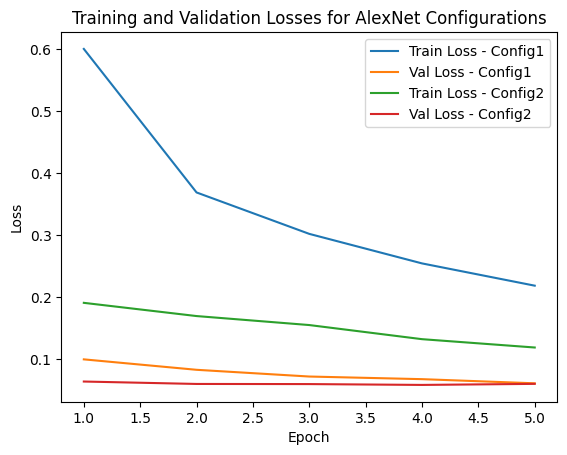

In [10]:
# Your graphs here and please provide comment in markdown in another cell
num_classes = 10
config1_alexnet.classifier[6] = nn.Linear(4096, num_classes)
config2_alexnet.classifier[6] = nn.Linear(4096, num_classes)

optimizer_c1 = optim.SGD(config1_alexnet.parameters(), lr=0.001, momentum=0.9)
optimizer_c2 = optim.SGD(config2_alexnet.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

#Training both the models 
num_epochs = 5
train_losses_c1, val_losses_c1 = train_model(config1_alexnet, optimizer_c1, criterion, train_loader, val_loader, num_epochs)
train_losses_c2, val_losses_c2 = train_model(config1_alexnet, optimizer_c1, criterion, train_loader, val_loader, num_epochs)

#Plotting
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses_c1, label='Train Loss - Config1')
plt.plot(epochs, val_losses_c1, label='Val Loss - Config1')
plt.plot(epochs, train_losses_c2, label='Train Loss - Config2')
plt.plot(epochs, val_losses_c2, label='Val Loss - Config2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for AlexNet Configurations')
plt.legend()
plt.show()

This plot shows the comparison in performance of the two configurations, and it shows that the training loss and validation loss are similar after a few set of epochs. 